# Neuroevolution
A small example on how to train an agent based on a neural network, which is trained with a genetic algorithm approach
 

## Import Dependencies & Generate the Environment and an Agent

In [1]:
##create the classes and prepare the data
import os, sys

sys.path.append(os.path.abspath("../Environments"))
sys.path.append(os.path.abspath("../Agents"))

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Environments.Order_Acceptance_and_Allocation import OAAP
from Agents.ga_agent import geneticalgorithm_interaction, genetic_network, evaluation
import numpy as np
import pygad
import pygad.torchga as torchga
import torch as T
import matplotlib.pyplot as plt

production_lines = 1
env = OAAP(episode_length = 20,
    production_lines = production_lines,
    nbr_resources_per_line = 6,
    resource_capacity = 6,
    min_rev = 1,
    max_rev = 9,
    action_space = [0, 1],
    order_set = None,
    penalty_reward = 20,
    len_static_data = 100)

agent = geneticalgorithm_interaction(production_lines, env)


## Define a neural network for that will used to determine the agents policy

In [2]:
# define the model
input_dims = [14]
fc1_dims = 64
fc2_dims = 64
# save model
path = "network_genetic_algorithm.zip"
# possible actions (rejection or acceptance)
n_actions = 2
model = genetic_network(input_dims, fc1_dims, fc2_dims, n_actions, path)

## Define the Parameter for the Genetic Algorithm Training

In [4]:
#define the GA approach
num_solutions = 250
torch_ga = torchga.TorchGA(model=model, num_solutions=num_solutions)
initial_population = torch_ga.population_weights
num_parents_mating = 25
num_generations = 250
parent_selection_type = "tournament"
crossover_type = "single_point"  # Type of the crossover operator
mutation_type = "random"
training_time = []
crossover_values = 0.15
mutation_values = 20
training_scores = np.zeros((2, int(num_generations)+2))
save_paths = ["network_genetic_algorithm_exp8.zip"]
ctr = 0

## Set up the Evaluation for the Population and Generate the Initial Set of Trainig Data

In [5]:
#create initial data set and define a evaluation classfor the training
static_order, order_rewards = env.create_static_data()
train = evaluation(static_order, order_rewards, model, input_dims, n_actions, path, env, num_solutions, agent) 
print(static_order)
print(order_rewards)


#train an agent
ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           sol_per_pop=num_solutions,
                           initial_population=initial_population,
                           fitness_func= train.fitness_func,
                           crossover_type=crossover_type,
                           parent_selection_type=parent_selection_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_values,
                           keep_parents=0,
                           on_generation=train.callback_generation,
                           save_best_solutions=False)

[[[2 2 1 1 0 0]
  [1 3 2 2 1 0]
  [1 3 2 2 1 0]
  ...
  [2 2 1 1 0 0]
  [0 2 2 0 0 0]
  [2 1 1 1 3 3]]

 [[1 3 2 2 1 0]
  [1 2 3 2 1 0]
  [1 1 1 1 0 0]
  ...
  [2 1 1 1 3 3]
  [1 2 3 2 1 0]
  [2 2 1 1 0 0]]

 [[2 2 1 1 0 0]
  [0 2 2 0 0 0]
  [1 3 2 2 1 0]
  ...
  [1 2 3 2 1 0]
  [1 2 3 2 1 0]
  [1 1 1 1 0 0]]

 ...

 [[1 1 1 1 0 0]
  [1 3 2 2 1 0]
  [1 2 3 2 1 0]
  ...
  [1 1 1 1 0 0]
  [1 2 3 2 1 0]
  [2 2 1 1 0 0]]

 [[2 2 1 1 0 0]
  [1 3 2 2 1 0]
  [1 3 2 2 1 0]
  ...
  [2 1 1 1 3 3]
  [1 1 1 1 0 0]
  [2 1 1 1 3 3]]

 [[1 2 3 2 1 0]
  [2 1 1 1 3 3]
  [1 3 2 2 1 0]
  ...
  [2 2 1 1 0 0]
  [0 2 2 0 0 0]
  [1 3 2 2 1 0]]]
[[24 45 63 ... 30 28 55]
 [ 9 45 36 ... 88 45 48]
 [48 32 54 ... 63 27  8]
 ...
 [24  9 18 ... 24  9 36]
 [18 27 72 ... 66 12 99]
 [81 33  9 ... 48 32  9]]


/home/flo/python_environments/ml/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


## Train the Agent

In [6]:
#register the ga instance in the evaluation class
train.register_instance(ga_instance)
ga_instance.run()


# Returning the details of the best solution.
results = ga_instance.best_solutions_fitness
    #return training data
solution, solution_fitness, solution_idx = ga_instance.best_solution()
results.append(solution_fitness)
print('results', results)
#save the network parameters
model = genetic_network(input_dims, fc1_dims, fc2_dims, n_actions, path)
model_weights_matrix = pygad.torchga.model_weights_as_dict(
        model=model, weights_vector=solution)
T.save(model_weights_matrix, path)

/home/flo/python_projects/RL/Agents/ga_agent.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  state = T.tensor([observation], dtype=T.float).to(self.model.device)


Generation = 1
Best Fitness (this gen) = 108.14000
Generation = 2
Best Fitness (this gen) = 118.56000
Generation = 3
Best Fitness (this gen) = 122.96000
Generation = 4
Best Fitness (this gen) = 122.96000
Generation = 5
Best Fitness (this gen) = 122.96000
Generation = 6
Best Fitness (this gen) = 122.96000
Generation = 7
Best Fitness (this gen) = 122.96000
Generation = 8
Best Fitness (this gen) = 127.54000
Generation = 9
Best Fitness (this gen) = 127.54000
Generation = 10
Best Fitness (this gen) = 127.54000
Generation = 11
Best Fitness (this gen) = 127.54000
Generation = 12
Best Fitness (this gen) = 127.54000
Generation = 13
Best Fitness (this gen) = 133.61000
Generation = 14
Best Fitness (this gen) = 133.61000
Generation = 15
Best Fitness (this gen) = 133.98000
Generation = 16
Best Fitness (this gen) = 133.98000
Generation = 17
Best Fitness (this gen) = 133.98000
Generation = 18
Best Fitness (this gen) = 133.98000
Generation = 19
Best Fitness (this gen) = 149.56000
Generation = 20
Best 

## Plot the results

The fitness value of the population might not change between Generations, since the Fitnessvalues of the parents, as well as the parents themself are handed over to the next generation

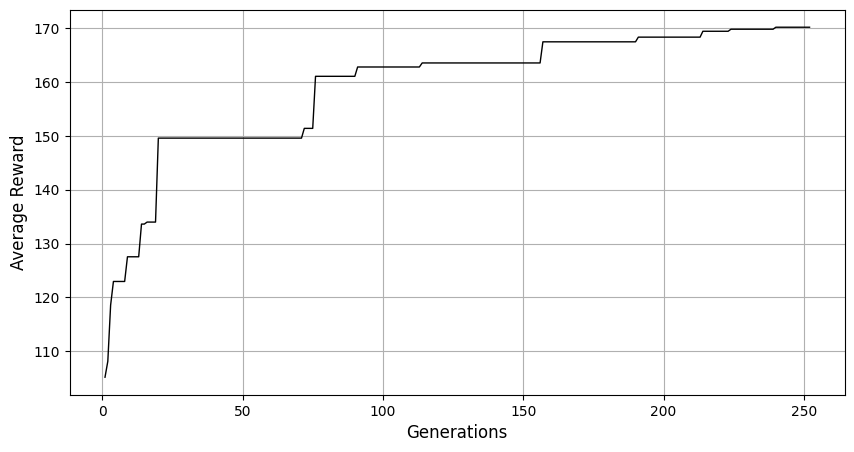

In [7]:
x = np.linspace(1,len(results),len(results))

plt.figure(figsize=(10,5))
plt.plot(x, results, color = 'black',linewidth =1, label = 'Agent')
plt.xlabel('Generations',fontsize=12)
plt.ylabel('Average Reward',fontsize=12)
plt.grid(True)
plt.show()